In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2

Autosaving every 180 seconds


# Imports

In [2]:
import random

from features import get_time_features
from utils import get_target
import os
import gc

import pandas as pd
pd.set_option('max_columns', None)

import numpy as np
from scipy import stats
from copy import deepcopy
import category_encoders as ce
from feature_engine.creation import CyclicalTransformer
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline

from reducing import Reducer
from features import num_transformations
from utils import downcast

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from utils import get_target

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Parameters

In [4]:
USE_FULL = False

data_path = 'data'
train_filename = 'training_set_VU_DM.csv'
test_filename = 'test_set_VU_DM.csv'

drop_cols = ['position', 'click_bool',
             'gross_bookings_usd', 'booking_bool',
#              'train', 'val', 'test', 'subm'
             ]

group_col = 'srch_id'
time_col = 'date_time'

FILTER_PRICE = True

COMP_RATE_PERCENT_DIFF_SIGNED_FEATURES = True
COMP_RATE_PERCENT_DIFF_TRANSFORMATION_FEATURES = False

BOOKING_TIME_FEATURES = False
BOOKING_TIME_CYCLICALS = False

HOLIDAY_DURING_TRIP_FEATURE = False
HOLIDAY_DURING_BOOKING_FEATURE = False
if HOLIDAY_DURING_TRIP_FEATURE or HOLIDAY_DURING_BOOKING_FEATURE:
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Data reading

In [5]:
dtps = {'srch_id': 'uint32',
        'date_time': 'object',
        'site_id': 'uint8',
        'visitor_location_country_id': 'uint8',
        'visitor_hist_starrating': 'float32',
        'visitor_hist_adr_usd': 'float32',
        'prop_country_id': 'uint8',
        'prop_id': 'uint32',
        'prop_starrating': 'float32',
        'prop_review_score': 'float32',
        'prop_brand_bool': 'uint8',
        'prop_location_score1': 'float32',
        'prop_location_score2': 'float32',
        'prop_log_historical_price': 'float32',
        'position': 'uint8',
        'price_usd': 'float32',
        'promotion_flag': 'uint8',
        'srch_destination_id': 'uint16',
        'srch_length_of_stay': 'uint8',
        'srch_booking_window': 'uint16',
        'srch_adults_count': 'uint8',
        'srch_children_count': 'uint8',
        'srch_room_count': 'uint8',
        'srch_saturday_night_bool': 'uint8',
        'srch_query_affinity_score': 'float32',
        'orig_destination_distance': 'float32',
        'random_bool': 'uint8',
        'comp1_rate': 'Int8',
        'comp1_inv': 'float32',
        'comp1_rate_percent_diff': 'float32',
        'comp2_rate': 'Int8',
        'comp2_inv': 'float32',
        'comp2_rate_percent_diff': 'float32',
        'comp3_rate': 'Int8',
        'comp3_inv': 'float32',
        'comp3_rate_percent_diff': 'float32',
        'comp4_rate': 'Int8',
        'comp4_inv': 'float32',
        'comp4_rate_percent_diff': 'float32',
        'comp5_rate': 'Int8',
        'comp5_inv': 'float32',
        'comp5_rate_percent_diff': 'float32',
        'comp6_rate': 'Int8',
        'comp6_inv': 'float32',
        'comp6_rate_percent_diff': 'float32',
        'comp7_rate': 'Int8',
        'comp7_inv': 'float32',
        'comp7_rate_percent_diff': 'float32',
        'comp8_rate': 'Int8',
        'comp8_inv': 'float32',
        'comp8_rate_percent_diff': 'float32',
        'click_bool': 'uint8',
        'gross_bookings_usd': 'float32',
        'booking_bool': 'uint8'}

In [6]:
from features_dict import features

if USE_FULL:
    df = pd.read_csv(os.path.join(data_path, train_filename),
                     dtype=dtps,
                     )
else:
#     p = 0.01
#     df = pd.read_csv(os.path.join(data_path, train_filename),
#                      #                      usecols=features['original_cols'],
#                      skiprows=lambda i: i > 0 and random.random() > p)
    df = pd.read_csv(os.path.join(data_path, train_filename),
                     dtype=dtps,
                     )
    df = df[df[group_col] < 33428]
df.shape

(499976, 54)

In [7]:
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3.0,3.5,1,2.83,0.0438,4.95,27,104.769997,0,23246,1,0,4,0,1,1,NaN,NaN,1,<NA>,NaN,NaN,0,0.0,NaN,0,0.0,NaN,<NA>,NaN,NaN,0,0.0,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4.0,4.0,1,2.20,0.0149,5.03,26,170.740005,0,23246,1,0,4,0,1,1,NaN,NaN,1,<NA>,NaN,NaN,<NA>,NaN,NaN,0,0.0,NaN,<NA>,NaN,NaN,0,1.0,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,0,0.0,NaN,0,NaN,0


In [8]:
if USE_FULL:
    subm_df = pd.read_csv(os.path.join(data_path, test_filename),
                          dtype=dtps
                          )
else:
    p = 0.01
    subm_df = pd.read_csv(os.path.join(data_path, test_filename),
#                           usecols=features['original_cols'],
                          skiprows=lambda i: i > 0 and random.random() > p)
subm_df.shape

(49786, 50)

# Split train, test, val (only add labels, keep the data in one df)

In [9]:
# df['test'] = False
# df.loc[(df[group_col] % 100).isin([0,1,2,3,4,5]), 'test'] = True

# df['val'] = False
# df.loc[(df[group_col] % 100).isin([6,7,8,9,10]), 'val'] = True

# df['train'] = False
# df.loc[(~df['test']) & (~df['val']), 'train'] = True

df['test'] = False
df.loc[df[group_col] % 10 == 5, 'test'] = True

df['val'] = False
df.loc[df[group_col] % 10 == 1, 'val'] = True

df['train'] = False
df.loc[(~df['test']) & (~df['val']), 'train'] = True

In [10]:
len_train = len(df[df['train']])
len_val = len(df[df['val']])
len_test = len(df[df['test']])

total_len = len_train + len_val + len_test
assert total_len == len(df)
len_train/len(df), len_val/len(df), len_test/len(df)

(0.8021605037041778, 0.09847872697889498, 0.09936076931692721)

In [11]:
df['subm']= False
subm_df['subm'] = True
df = pd.concat([df, subm_df])

df['date_time'] = pd.to_datetime(df['date_time'])

df['train'].fillna(False, inplace=True)
df['test'].fillna(False, inplace=True)
df['val'].fillna(False, inplace=True)

In [12]:
df[(df[group_col] % 100) == 11][[group_col, 'train', 'val', 'test', 'subm']]

,srch_id,train,val,test,subm
86,11,False,True,False,False
87,11,False,True,False,False
88,11,False,True,False,False
89,11,False,True,False,False
90,11,False,True,False,False
...,...,...,...,...,...
49138,328611,False,False,False,True
49170,328811,False,False,False,True
49203,329011,False,False,False,True
49334,329911,False,False,False,True


In [13]:
df.memory_usage().sum() / 1024**2

234.8836669921875

In [14]:
assert set(df[df['train']].index).intersection(set(df[df['val']].index)) == set()
assert set(df[df['train']].index).intersection(set(df[df['test']].index)) == set()
assert set(df[df['val']].index).intersection(set(df[df['test']].index)) == set()

In [15]:
assert df[df[['train', 'val', 'test', 'subm']].sum(axis=1) != 1].empty

# Missing values

**srch_query_affinity_score** - The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative). A null signifies there are no data (i.e. hotel did not register in any searches)  
NO ACTION REQUIRED - ALREADY HAS NANS

**prop_log_historical_price** - The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative)  A null signifies there are no data (i.e. hotel did not register in any searches)

In [16]:
# df['was_sold_in_that_period'] = df['prop_log_historical_price'].apply(bool)
df['prop_log_historical_price'].replace(0, np.nan, inplace=True)

In [17]:
df['prop_starrating'].replace(0, np.nan, inplace=True)
df['visitor_hist_adr_usd'].replace(0, np.nan, inplace=True)

In [18]:
df.isna().any(axis=0)

srch_id                        False
date_time                      False
site_id                        False
visitor_location_country_id    False
visitor_hist_starrating         True
visitor_hist_adr_usd            True
prop_country_id                False
prop_id                        False
prop_starrating                 True
prop_review_score               True
prop_brand_bool                False
prop_location_score1           False
prop_location_score2            True
prop_log_historical_price       True
position                        True
price_usd                      False
promotion_flag                 False
srch_destination_id            False
srch_length_of_stay            False
srch_booking_window            False
srch_adults_count              False
srch_children_count            False
srch_room_count                False
srch_saturday_night_bool       False
srch_query_affinity_score       True
orig_destination_distance       True
random_bool                    False
c

# Money fix

Some Hotels use price/day, other use price/trip  
Try to find what price hotels showed and create features price_per_day and price_per_trip

**gross_booking_usd** - Total value of the transaction.  This can differ from the price_usd due to taxes, fees, conventions on multiple day bookings and purchase of a room type other than the one shown in the search
ID of the destination where the hotel search was performed

In [19]:
# calculate difference between gross_bookings_usd and price_usd
# also calculate difference between gross_bookings_usd and srch_length_of_stay * price_usd

df['gross_price_diff'] = df['gross_bookings_usd'] - df['price_usd']
df['adj_price_diff'] = df['gross_bookings_usd'] - (df['srch_length_of_stay'] * df['price_usd'])

In [20]:
# price is given per day if srch_length_of_stay * price_usd is closer to gross_bookings_usd than
# price_usd

df['price_per_day_given'] = abs(df['adj_price_diff']) < abs(df['gross_price_diff'])

In [21]:
df['price_per_day_given'].value_counts()

False    542893
True       6869
Name: price_per_day_given, dtype: int64

In [22]:
# only prop_id is correlated with price_per_day_given, other columns did not give good results
# so we find the prop_id that use price per day

prop_id_with_price_per_day = df.groupby(
    'prop_id')['price_per_day_given'].mean().apply(lambda x: x > 0.5).index

In [23]:
# adjust price_per_day where price is given for whole trip
# and adjust price_per_trip where price is given per day

df['price_per_day'] = df['price_usd']
df['price_per_trip'] = df['price_usd']

df.loc[df['prop_id'].isin(prop_id_with_price_per_day), 'price_per_trip'] = df['price_per_day'] * df['srch_length_of_stay']
df.loc[~df['prop_id'].isin(prop_id_with_price_per_day), 'price_per_day'] = df['price_per_day'] / df['srch_length_of_stay']


In [24]:
# drop columns that helped creating price_per_day and price_per_trip but are not useful anymore

df.drop(['gross_price_diff', 'adj_price_diff', 'price_per_day_given'], axis=1, inplace=True)

# Outliers detection

## Filter price_usd

In [25]:
df['subm'].value_counts()

False    499976
True      49786
Name: subm, dtype: int64

<AxesSubplot:>

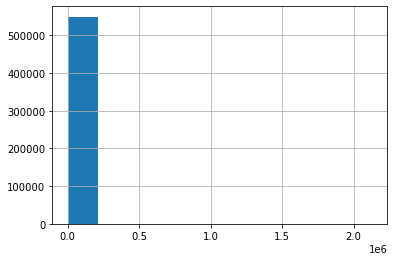

In [26]:
df['price_usd'].hist()

In [27]:
if FILTER_PRICE:
    print('ratio of 15k+ prices', round(len(df[df['price_usd'] > 15000])/len(df), 7))
    df['price_usd'] = df['price_usd'].clip(0, 15000)

ratio of 15k+ prices 0.0003347


<AxesSubplot:>

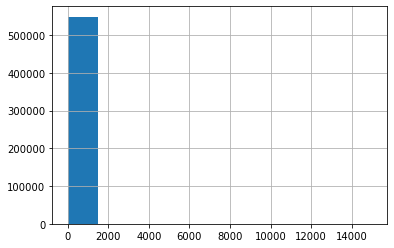

In [28]:
df['price_usd'].hist()

In [29]:
if FILTER_PRICE:
    # DANGEROUS to calculate statistics based on everything
    # filter outlieing prices per prop_id
    # still some outlier_prop_ids left
    mean = df.groupby(['prop_id'])['price_usd'].transform('mean')    
    std = df.groupby(['prop_id'])['price_usd'].transform('std')
    
#     subm_df = deepcopy(df[df['subm'] == True])
#     df = deepcopy(df[df['subm'] == False])
    
    # find rows and prop_id with outlieing prices compared to other prices per prop_id
    df['sigma'] = abs((df['price_usd'] - mean) / std)
    outlier_prop_ids = df[df['sigma'] > 4]['prop_id']
    print(f"num and ratio of outlier props: {len(outlier_prop_ids)} ({round(len(outlier_prop_ids)/df['prop_id'].nunique(), 7)})")
    correct_entries = df[abs((df['price_usd'] - mean) / std) <= 2]['prop_id']
    
    # show the prices for the first property with an outlier
    display(df[df['prop_id'].isin(outlier_prop_ids.sample(1))][['prop_id', 'date_time', 'price_usd', 'sigma']].sort_values('date_time'))
    df.drop('sigma', axis=1, inplace=True)

num and ratio of outlier props: 893 (0.0106043)


,prop_id,date_time,price_usd,sigma
16864,106262,2012-11-04 12:22:37,295.0,0.249382
464575,106262,2012-11-08 09:36:12,445.0,0.014177
361059,106262,2012-11-10 04:14:25,592.0,0.216324
462537,106262,2012-11-11 06:55:45,425.0,0.045537
21255,106262,2012-11-13 11:38:38,345.0,0.170980
...,...,...,...,...
156231,106262,2013-06-10 18:02:02,295.0,0.249382
73450,106262,2013-06-13 09:22:35,378.0,0.119235
308825,106262,2013-06-14 00:54:19,482.0,0.043840
254269,106262,2013-06-21 12:48:48,295.0,0.249382


if group is not in subm, if there is an outlier in a group, and the group is random, drop it

In [30]:
if FILTER_PRICE:
    affected_train_groups = df[(df['subm'] == False) & (df['prop_id'].isin(outlier_prop_ids)) & (df['random_bool'] == True)][group_col]
    print('ratio of affected groups', len(affected_train_groups) / df[group_col].nunique())

ratio of affected groups 0.18040282534948132


In [31]:
df.shape

(549762, 60)

In [32]:
if FILTER_PRICE:
    df = df[~df[group_col].isin(affected_train_groups)]
df.shape

(492770, 60)

<AxesSubplot:>

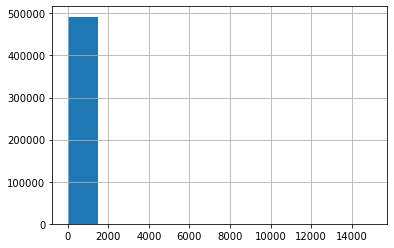

In [33]:
df['price_usd'].hist()

<AxesSubplot:>

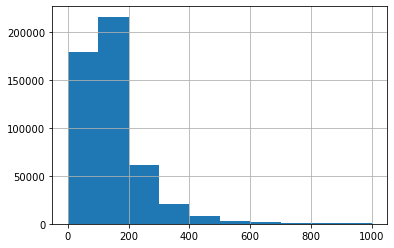

In [34]:
df[df['price_usd'] < 1000]['price_usd'].hist()

<AxesSubplot:>

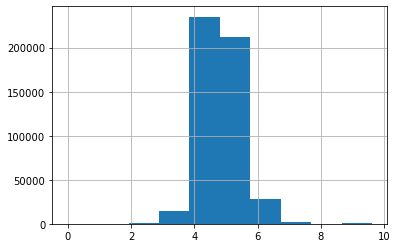

In [35]:
df['price_usd'].apply(np.log1p).hist()

In [36]:
# if FILTER_PRICE:
#     # show the prices for the first property after removing the outlier
# #     df[df['prop_id'].isin(outliers.values[:1])][df[df['prop_id'].isin(
# #         outliers.values[:1])]['price_usd'].index.isin(correct_entries.index)][['prop_id','price_usd']].head()

#     # calculate the mean price for properties with an outlier without the outlier
#     mean_price_per_prop_id = df[df['prop_id'].isin(outliers.values)][df[df['prop_id'].isin(outliers.values)]['price_usd'].index.isin(
#         correct_entries.index)][['prop_id','price_usd']].groupby('prop_id').mean()

#     df2 = pd.merge(df.loc[outliers.index], mean_price_per_prop_id, right_index=True, left_on = 'prop_id', how='left')
    
#     # outliers within the first prop_id 
#     # price_usd_x: original
#     # price_usd_y: after replaceing with mean
#     df2[df2['prop_id'].isin(outliers.values[:1])][['prop_id','price_usd_x', 'price_usd_y']]
    
#     # keep only price_usd_y, drop price_usd_x
#     df2 = df2.rename(columns={'price_usd_y': 'price_usd'}).drop('price_usd_x', axis=1)
    
#     # correct the outlieing prices in the original df
#     df.loc[outliers.index, 'price_usd'] = df2['price_usd']
    
# #     df['price_usd'].hist(bins=100, log=True)

#     assert df['price_usd'].isna().sum() == 0
    
#     # fill missing prices with mean
#     df['price_usd'].fillna(df['price_usd'].mean(), inplace=True)
    
#     df.loc[stats.zscore(df['price_usd']) > 3, 'price_usd'] = df['price_usd'].mean()
    
#     # filter outlieing prices overall (based on train here)
#     # the limit is around 20.000 USD, above that there is only 1 entry per price bracket -> mistake
#     df['price_usd'].hist(bins=100, log=True)
    
#     df = pd.concat([df, subm_df])

In [37]:
df['subm'].value_counts()

False    443278
True      49492
Name: subm, dtype: int64

# Time-independent feature engineering

## Booking time decomposition

In [38]:
df.sort_values([time_col], inplace=True)

In [39]:
if BOOKING_TIME_FEATURES:
    booking_time_prefix = 'booking_time_'

    # various time-related columns are added to the df
    time_df = get_time_features(deepcopy(df[['date_time']]), time_col='date_time',
                                prefix=booking_time_prefix,
                                within_hour_features=False,
                                hour_features=False,
                                day_features=True,
                                week_features=True,
                                month_features=True,
                                season_features=True,
                                year_features=True,)

    display(time_df.head(2))

In [40]:
enc = ce.OrdinalEncoder(cols=['date_time'])

if BOOKING_TIME_FEATURES:
    # time column is encoded as some algorithms don't work with datetime. 
    # keep both. each specific model may load needed columns
    time_df = enc.fit_transform(time_df)
else:
    time_df = enc.fit_transform(df['date_time'])

time_df.rename(columns={"date_time": "date_time_ordinal"}, inplace=True)
df = pd.concat([df, time_df], axis=1)
    
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal
6744,45562,2012-11-01 00:28:53,24,216,NaN,NaN,219,14944,3.0,4.5,0,5.18,0.2439,5.65,NaN,197.780000,0,9402,6,342,1,0,1,0,NaN,NaN,0,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,False,False,False,True,197.780000,1186.680000,1
43627,292691,2012-11-01 00:31:19,24,216,NaN,NaN,219,44883,2.0,3.0,0,3.91,0.1575,4.78,NaN,71.340000,1,9358,3,103,2,0,1,0,NaN,NaN,1,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,False,False,False,True,71.340000,214.020000,2
390355,26168,2012-11-01 00:35:47,32,220,NaN,NaN,219,95166,3.0,4.0,1,2.71,0.0811,4.71,14.0,80.080002,1,25964,1,46,1,0,1,0,NaN,7935.899902,0,<NA>,NaN,NaN,1.0,0.0,13.0,0.0,0.0,17.0,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,0.0,0.0,12.0,0.0,NaN,0.0,False,False,True,False,80.080002,80.080002,3
390344,26168,2012-11-01 00:35:47,32,220,NaN,NaN,219,63762,2.0,4.5,1,2.08,0.0507,4.73,30.0,79.040001,0,25964,1,46,1,0,1,0,NaN,7936.379883,0,<NA>,NaN,NaN,0.0,0.0,NaN,<NA>,1.0,NaN,<NA>,NaN,NaN,1.0,0.0,3.0,<NA>,NaN,NaN,<NA>,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,False,False,True,False,79.040001,79.040001,3
390345,26168,2012-11-01 00:35:47,32,220,NaN,NaN,219,64777,3.0,4.0,1,2.83,0.0550,4.85,6.0,105.040001,0,25964,1,46,1,0,1,0,NaN,7936.209961,0,<NA>,NaN,NaN,0.0,0.0,NaN,<NA>,1.0,NaN,<NA>,NaN,NaN,0.0,0.0,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,False,False,True,False,105.040001,105.040001,3


In [41]:
df.shape

(492770, 61)

### Time cyclicals

In [42]:
if BOOKING_TIME_CYCLICALS:
    max_values_dict = {
        booking_time_prefix + 'day': 31,
        booking_time_prefix + 'month': 12,
        booking_time_prefix + 'quarter': 4,
        booking_time_prefix + 'week': 52,
        booking_time_prefix + 'dow': 7,
        booking_time_prefix + 'doy': 366,
        booking_time_prefix + 'season_num': 4
    }

    cyclical = CyclicalTransformer(variables=list(max_values_dict.keys()),
                                   drop_original=False,
                                   max_values=max_values_dict)

    df = cyclical.fit_transform(df)
    df.head()

## Distance and locations

In [43]:
# df['trans_ocean'] = df['orig_destination_distance'] > 3000
# df['travel_inside'] = df['visitor_location_country_id'] == df['prop_country_id']

In [44]:
df['prop_location_score_diff'] = df['prop_location_score1'] - df['prop_location_score2']
# df['prop_location_score_diff_7'] = df['prop_location_score1'] - df['prop_location_score2'] * 7
df['prop_location_score_sum'] = df['prop_location_score1'] + df['prop_location_score2']
# df['prop_location_score_sum_7'] = df['prop_location_score1'] + df['prop_location_score2'] * 7
df['prop_location_score_mul'] = df['prop_location_score1'] * df['prop_location_score2']

In [45]:
df['prop_location_score_diff_log'] = df['prop_location_score1'] - (np.log(df['prop_location_score2'] + 1e-6) / np.log(2))
df['prop_location_score_sum_log'] = df['prop_location_score1'] + (np.log(df['prop_location_score2'] + 1e-6) / np.log(2))
df['prop_location_score_mul_log'] = df['prop_location_score1'] * (np.log(df['prop_location_score2'] + 1e-6) / np.log(2))

## Competitors

**comp1_rate** - +1 if Expedia has a lower price than competitor 1 for the hotel; 0 if the same; -1 if Expedia’s price is higher than competitor 1; null signifies there is no competitive data  

**comp1_inv** - +1 if competitor 1 does not have availability in the hotel; 0 if both Expedia and competitor 1 have availability; null signifies there is no competitive data

**comp1_rate_percent_diff** - The absolute percentage difference (if one exists) between Expedia and competitor 1’s price (Expedia’s price the denominator); null signifies there is no competitive data

In [46]:
# for i in range(1, 9):
#     print(df[df[f'comp{i}_rate'] == 0][f'comp{i}_rate_percent_diff'].value_counts(dropna=False))

In [47]:


df['higher_price_than_expedia'] = 0  # 0 to nan
df['lower_price_than_expedia'] = 0  # 0 to nan
df['same_price_as_expedia'] = 0  # 0 to nan
df['comp_num_avail'] = 0
df['comp_num_avail_nan'] = 0

for i in range(1, 9):
    df.loc[df[f'comp{i}_rate'] == 1, 'higher_price_than_expedia'] += 1
    df.loc[df[f'comp{i}_rate'] == -1, 'lower_price_than_expedia'] += 1
    df.loc[df[f'comp{i}_rate'] == 0, 'same_price_as_expedia'] += 1 
    
    df.loc[df[f'comp{i}_inv'] == 0, 'comp_num_avail'] += 1 
    df.loc[df[f'comp{i}_inv'].isna(), 'comp_num_avail_nan'] += 1 
    
df.loc[df['comp_num_avail_nan'] == 8, 'comp_num_avail'] = np.nan
df.drop(['comp_num_avail_nan'], axis=1, inplace=True)

df['higher_price_than_expedia'].replace(0, np.nan, inplace=True)
df['lower_price_than_expedia'].replace(0, np.nan, inplace=True)
df['same_price_as_expedia'].replace(0, np.nan, inplace=True)

df['ratio_of_comp_with_higher_price_than_expedia'] = df['higher_price_than_expedia'] / df['comp_num_avail']
df['ratio_of_comp_with_lower_price_than_expedia'] = df['lower_price_than_expedia'] / df['comp_num_avail']

In [48]:
if COMP_RATE_PERCENT_DIFF_SIGNED_FEATURES:
    for i in range(1, 9):
        df[f'comp{i}_rate_percent_diff_signed'] = df[f'comp{i}_rate'] * df[f'comp{i}_rate_percent_diff']
        df.drop([f'comp{i}_rate'], axis=1, inplace=True)

In [49]:
# if COMP_RATE_PERCENT_DIFF_TRANSFORMATION_FEATURES:
#     df = num_transformations(df,
#                          [f'comp{i}_rate_percent_diff' for i in range(1, 9)],
#                          powers=[],
#                          log_bases=[2, 10], 
#                          do_reciprocal=False,
#                          do_exp=False)
# else:
#     for i in range(1, 9):
#         df.drop([f'comp{i}_rate_percent_diff'], axis=1, inplace=True)  # bcs it's just a sign for the new feature

In [50]:
df.shape

(492770, 73)

In [51]:
df.drop([
    'comp1_inv',
    'comp1_rate_percent_diff',
    'comp2_inv',
    'comp2_rate_percent_diff',
    'comp3_inv',
    'comp3_rate_percent_diff',
    'comp4_inv',
    'comp4_rate_percent_diff',
    'comp5_inv',
    'comp5_rate_percent_diff',
    'comp6_inv',
    'comp6_rate_percent_diff',
    'comp7_inv',
    'comp7_rate_percent_diff',
    'comp8_inv',
    'comp8_rate_percent_diff',
    'higher_price_than_expedia',
    'lower_price_than_expedia',
    'same_price_as_expedia',
    'comp_num_avail',
    'ratio_of_comp_with_higher_price_than_expedia',
    'comp1_rate_percent_diff_signed',
    'comp2_rate_percent_diff_signed',
    'comp3_rate_percent_diff_signed',
    'comp4_rate_percent_diff_signed',
    'comp6_rate_percent_diff_signed',
    'comp7_rate_percent_diff_signed',
],
        axis=1,
        inplace=True)

In [52]:
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed
6744,45562,2012-11-01 00:28:53,24,216,NaN,NaN,219,14944,3.0,4.5,0,5.18,0.2439,5.65,NaN,197.780000,0,9402,6,342,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,False,False,False,True,197.780000,1186.680000,1,4.9361,5.4239,1.263402,7.215632,3.144368,-10.544576,NaN,<NA>,<NA>
43627,292691,2012-11-01 00:31:19,24,216,NaN,NaN,219,44883,2.0,3.0,0,3.91,0.1575,4.78,NaN,71.340000,1,9358,3,103,2,0,1,0,NaN,NaN,1,NaN,NaN,NaN,False,False,False,True,71.340000,214.020000,2,3.7525,4.0675,0.615825,6.576567,1.243433,-10.426277,NaN,<NA>,<NA>
390355,26168,2012-11-01 00:35:47,32,220,NaN,NaN,219,95166,3.0,4.0,1,2.71,0.0811,4.71,14.0,80.080002,1,25964,1,46,1,0,1,0,NaN,7935.899902,0,0.0,NaN,0.0,False,False,True,False,80.080002,80.080002,3,2.6289,2.7911,0.219781,6.334136,-0.914136,-9.821410,NaN,<NA>,0.0
390344,26168,2012-11-01 00:35:47,32,220,NaN,NaN,219,63762,2.0,4.5,1,2.08,0.0507,4.73,30.0,79.040001,0,25964,1,46,1,0,1,0,NaN,7936.379883,0,0.0,NaN,0.0,False,False,True,False,79.040001,79.040001,3,2.0293,2.1307,0.105456,6.381842,-2.221842,-8.947831,NaN,3.0,NaN
390345,26168,2012-11-01 00:35:47,32,220,NaN,NaN,219,64777,3.0,4.0,1,2.83,0.0550,4.85,6.0,105.040001,0,25964,1,46,1,0,1,0,NaN,7936.209961,0,0.0,NaN,0.0,False,False,True,False,105.040001,105.040001,3,2.7750,2.8850,0.155650,7.014398,-1.354398,-11.841847,NaN,NaN,NaN


In [53]:
df.shape

(492770, 46)

## Money features

### Money transformations

In [54]:
df = num_transformations(df,
                         [
#                              'price_usd', 
                          'price_per_day'],
                         powers=[2, 3],
                         log_bases=[10])

In [55]:
# df = num_transformations(df,
#                          [
# #                              'visitor_hist_adr_usd',
# #                           'price_per_trip'
#                          ],
#                          powers=[0.33, 0.5, 2, 3],
#                          log_bases=[2, 10, round(np.e, 2)])

In [56]:
df = num_transformations(df, ['prop_log_historical_price'],
                         powers=[0.33],
                         log_bases=[10],
                         do_exp=False)

**prop_log_historical_price** - The logarithm of the mean price of the hotel over the last trading period. A 0 will occur if the hotel was not sold in that period.  

In [57]:
df['prop_historical_price'] = np.exp(df['prop_log_historical_price'])

**visitor_hist_adr_usd** - The mean price per night (in US$) of the hotels the customer has previously purchased; null signifies there is no purchase history on the customer  

**price_usd** - Displayed price of the hotel for the given search.  Note that different countries have different conventions regarding displaying taxes and fees and the value may be per night or for the whole stay

In [58]:
df['price_diff_to_usr_hist'] = df['price_usd'] - df['visitor_hist_adr_usd']
df['price_ratio_to_usr_hist'] = df['price_usd'] / (df['visitor_hist_adr_usd'] + 1e-2)

df['price_per_day_diff_to_usr_hist'] = df['price_per_day'] - df['visitor_hist_adr_usd']
df['price_per_day_ratio_to_usr_hist'] = df['price_per_day'] / (df['visitor_hist_adr_usd'] + 1e-2)

df['price_per_trip_diff_to_usr_hist'] = df['price_per_trip'] - df['visitor_hist_adr_usd']
df['price_per_trip_ratio_to_usr_hist'] = df['price_per_trip'] / (df['visitor_hist_adr_usd'] + 1e-2)

df['price_diff_to_place_hist_price'] = df['price_usd'] - np.exp(df['prop_log_historical_price'])
df['price_per_day_diff_to_place_hist_price'] = df['price_per_day'] - np.exp(df['prop_log_historical_price'])
df['price_per_trip_diff_to_place_hist_price'] = df['price_per_trip'] - np.exp(df['prop_log_historical_price'])
df['place_hist_price_diff_usr_hist'] = np.exp(df['prop_log_historical_price']) - df['visitor_hist_adr_usd']

In [59]:
# totally missed in submission df
# df['usr_extra_pay'] = df['gross_bookings_usd'] - df['price_usd']

## Stars

**visitor_hist_starrating** - The mean star rating of hotels the customer has previously purchased; null signifies there is no purchase history on the customer

**prop_starrating** - The star rating of the hotel, from 1 to 5, in increments of 1.  A 0 indicates the property has no stars, the star rating is not known or cannot be publicized.

**prop_review_score** - The mean customer review score for the hotel on a scale out of 5, rounded to 0.5 increments. A 0 means there have been no reviews, null that the information is not available.

In [60]:
df['prop_star_usr_hist_diff'] = df['prop_starrating'] - df['visitor_hist_starrating']
df['prop_review_usr_hist_diff'] = df['prop_review_score'] - df['visitor_hist_starrating']

df['prop_starrating_bonus_chain'] = df['prop_starrating'] + df['prop_brand_bool']

In [61]:


df['prop_star_review_sum'] = df['prop_starrating'] + df['prop_review_score']
df['prop_star_review_diff'] = df['prop_starrating'] - df['prop_review_score']
df['prop_star_review_min'] = df[['prop_starrating', 'prop_review_score']].parallel_apply(min, axis=1)
df['prop_star_review_max'] = df[['prop_starrating', 'prop_review_score']].parallel_apply(max, axis=1)
df['prop_star_review_mean'] = df[['prop_starrating', 'prop_review_score']].parallel_apply(np.mean, axis=1)

### Price\star

In [62]:
df['price_per_star'] = df['price_per_day'] / (df['prop_starrating'] + 1e-6)
df['price_per_review_score'] = df['price_per_day'] / (df['prop_review_score'] + 1e-6)

# df['usr_price_per_star'] = df['visitor_hist_adr_usd'] / df['visitor_hist_starrating']

# df['price_per_star_diff_with_usr'] = df['price_per_star'] - df['usr_price_per_star']
# df['price_per_review_diff_with_usr'] = df['price_per_review_score'] - df['usr_price_per_star']

In [63]:
df = num_transformations(df,
                         ['price_per_star', 'price_per_review_score', 
#                           'usr_price_per_star'
                         ],
                         powers=[],
                         log_bases=[10], 
                         do_reciprocal=False,
                         do_exp=False)

In [64]:
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10
6744,45562,2012-11-01 00:28:53,24,216,NaN,NaN,219,14944,3.0,4.5,0,5.18,0.2439,5.65,NaN,197.78,0,9402,6,342,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,False,False,False,True,197.78,1186.68,1,4.9361,5.4239,1.263402,7.215632,3.144368,-10.544576,NaN,<NA>,<NA>,39116.9284,2.296182,0.005056,1.770826,0.752049,0.176991,284.291466,NaN,NaN,NaN,NaN,NaN,NaN,-86.511466,-86.511466,902.388534,NaN,NaN,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,65.926645,43.951101,1.819061,1.642970
43627,292691,2012-11-01 00:31:19,24,216,NaN,NaN,219,44883,2.0,3.0,0,3.91,0.1575,4.78,NaN,71.34,1,9358,3,103,2,0,1,0,NaN,NaN,1,NaN,NaN,NaN,False,False,False,True,71.34,214.02,2,3.7525,4.0675,0.615825,6.576567,1.243433,-10.426277,NaN,<NA>,<NA>,5089.3956,1.853333,0.014017,1.675758,0.679428,0.209205,119.104350,NaN,NaN,NaN,NaN,NaN,NaN,-47.764350,-47.764350,94.915650,NaN,NaN,NaN,2.0,5.0,-1.0,2.0,3.0,2.50,35.669982,23.779992,1.552303,1.376212


In [65]:
df.shape

(492770, 75)

## Days of staying

**srch_length_of_stay** - Number of nights stay that was searched


**srch_booking_window** - Number of days in the future the hotel stay started from the search date

In [66]:
df['booking_weeks_ahead'] = df['srch_booking_window'] / 7
# df['booking_months_ahead'] = df['srch_booking_window'] / 30

df['len_of_stay_to_booking_ahead_ratio'] = df['srch_booking_window'] / df['srch_length_of_stay']
# df['len_of_stay_to_booking_ahead_diff'] = df['srch_booking_window'] - df['srch_length_of_stay']

In [67]:
# df['srch_length_of_stay_in_weeks'] = df['srch_length_of_stay'] // 7
# df['srch_length_of_stay_in_weeks'].value_counts()

### Calculate date of trip
from: date_time + srch_booking_window\
until: date_time + srch_booking_window + srch_length_of_stay

In [68]:
df['date'] = df['date_time'].dt.floor('D')
df['days_until_trip'] = pd.to_timedelta(df['srch_booking_window'], unit='D')

df['trip_start_date'] = df['date'] + df['days_until_trip']
df['trip_end_date'] = df['date'] + df['days_until_trip'] + pd.to_timedelta(df['srch_length_of_stay'], unit='D')

df.drop(['days_until_trip'], axis=1, inplace=True)

In [69]:
trip_start = get_time_features(deepcopy(df[['trip_start_date']]), time_col='trip_start_date', 
                               prefix='trip_start_date_', 
                               within_hour_features=False, hour_features=False,
                               day_features=False, week_features=True, month_features=True, 
                               season_features=True, year_features=True)
trip_start.drop('trip_start_date', axis=1, inplace=True)
# trip_start.drop([c for c in trip_start.columns if 'week' not in c], axis=1, inplace=True)
trip_start.head(2)

,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id
6744,41,13,10,31,4,4,2013,201341
43627,7,4,2,28,1,1,2013,201307


In [70]:
trip_end = get_time_features(deepcopy(df[['trip_end_date']]), time_col='trip_end_date', 
                               prefix='trip_end_date_', 
                               within_hour_features=False, hour_features=False,
                               day_features=False, week_features=True, month_features=True, 
                               season_features=True, year_features=True)
trip_end.drop('trip_end_date', axis=1, inplace=True)
# trip_end.drop([c for c in trip_end.columns if 'week' not in c], axis=1, inplace=True)
trip_end.head(2)

,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id
6744,42,12,10,31,4,4,2013,201342
43627,7,4,2,28,1,1,2013,201307


In [71]:
df = pd.concat([df, trip_start, trip_end], axis=1)

In [72]:
df.shape

(492770, 96)

### Count holidays (work free day) during the trip

In [73]:
if HOLIDAY_DURING_TRIP_FEATURE:
    cal = calendar()
    # holidays = cal.holidays(start=min(df['trip_start_date']), end=max(df['trip_end_date']))

    holidays = cal.holidays(start=min(df['trip_start_date']), end=max(df['trip_end_date']), return_name=True)
   
    df['holidays_during_trip'] = np.nan
    # for holiday in holidays:
    #     df['holidays_during_trip'] += (df['trip_start_date'] <= holiday) & (df['trip_end_date'] >= holiday)

    for holiday in holidays.items():
        print(holiday[0], holiday[1])
        df.loc[(df['trip_start_date'] <= holiday[0]) & (df['trip_end_date'] >= holiday[0]), 'holiday_during_trip'] = holiday[1]

In [74]:
if HOLIDAY_DURING_TRIP_FEATURE:
    df['holiday_during_trip'].value_counts(dropna=False)

add some number of days before and after. weight them

### Holidays during the day of booking

In [75]:
if HOLIDAY_DURING_BOOKING_FEATURE:
    df['holiday_during_booking'] = np.nan

    for holiday in holidays.items():
        print(holiday[0], holiday[1])
        df.loc[(df['date'] == holiday[0]), 'holiday_during_booking'] = holiday[1]        

In [76]:
if HOLIDAY_DURING_BOOKING_FEATURE:
    df['holiday_during_booking'].value_counts(dropna=False)

### Try to separate business trips from holidays

sign for worktrip:\
srch_children_count = 0\
srch_adults_count = 1\
srch_saturday_night_bool = False\
srch_length_of_stay < avg\
orig_destination_distance < avg\
srch_booking_window < avg

In [77]:
# df['business_trip'] = False
# df.loc[(df['srch_children_count'] == 0) & (df['srch_adults_count'] == 1) &
#        (~df['srch_saturday_night_bool']) & (df['srch_length_of_stay'] <= 5), 'business_trip'] = True

## Family

**srch_adults_count** - The number of adults specified in the hotel room

 
**srch_children_count** - The number of (extra occupancy) children specified in the hotel room

 
**srch_room_count** - Number of hotel rooms specified in the search

In [78]:
df['children_per_adult'] = df['srch_children_count'] / df['srch_adults_count']
df['total_people'] = df['srch_children_count'] + df['srch_adults_count']
df['people_per_room'] = df['total_people'] / df['srch_room_count']

df['separate_children_room'] = df['srch_children_count'] & (df['srch_room_count'] > 1)

## Normalize

In [79]:
from features import normalize_features

In [80]:
df[df['price_usd'] < 0]['price_usd']

Series([], Name: price_usd, dtype: float64)

In [81]:
df = normalize_features(df, group_key="srch_id", 
                        target_column="price_usd",
                        take_log10=True,
                       )
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date,trip_end_date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id
0,45562,2012-11-01 00:28:53,24,216,NaN,NaN,219,14944,3.0,4.5,0,5.18,0.2439,5.65,NaN,197.78,0,9402,6,342,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,False,False,False,True,197.78,1186.68,1,4.9361,5.4239,1.263402,7.215632,3.144368,-10.544576,NaN,<NA>,<NA>,39116.9284,2.296182,0.005056,1.770826,0.752049,0.176991,284.291466,NaN,NaN,NaN,NaN,NaN,NaN,-86.511466,-86.511466,902.388534,NaN,NaN,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,65.926645,43.951101,1.819061,1.642970,48.857143,57.000000,2012-11-01,2013-10-09,2013-10-15,41,13,10,31,4,4,2013,201341,42,12,10,31,4,4,2013,201342,0.0,1,1.0,False,NaN
1,292691,2012-11-01 00:31:19,24,216,NaN,NaN,219,44883,2.0,3.0,0,3.91,0.1575,4.78,NaN,71.34,1,9358,3,103,2,0,1,0,NaN,NaN,1,NaN,NaN,NaN,False,False,False,True,71.34,214.02,2,3.7525,4.0675,0.615825,6.576567,1.243433,-10.426277,NaN,<NA>,<NA>,5089.3956,1.853333,0.014017,1.675758,0.679428,0.209205,119.104350,NaN,NaN,NaN,NaN,NaN,NaN,-47.764350,-47.764350,94.915650,NaN,NaN,NaN,2.0,5.0,-1.0,2.0,3.0,2.50,35.669982,23.779992,1.552303,1.376212,14.714286,34.333333,2012-11-01,2013-02-12,2013-02-15,7,4,2,28,1,1,2013,201307,7,4,2,28,1,1,2013,201307,0.0,2,2.0,False,NaN


In [82]:
df['price_usd_log10_norm_by_srch_id'].isna().mean()

0.07256123546482132

In [83]:
df = normalize_features(df, group_key="prop_id", 
                        target_column="price_usd",
                        take_log10=True,
                       )
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date,trip_end_date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id,price_usd_log10_norm_by_prop_id
0,45562,2012-11-01 00:28:53,24,216,NaN,NaN,219,14944,3.0,4.5,0,5.18,0.2439,5.65,NaN,197.78,0,9402,6,342,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,False,False,False,True,197.78,1186.68,1,4.9361,5.4239,1.263402,7.215632,3.144368,-10.544576,NaN,<NA>,<NA>,39116.9284,2.296182,0.005056,1.770826,0.752049,0.176991,284.291466,NaN,NaN,NaN,NaN,NaN,NaN,-86.511466,-86.511466,902.388534,NaN,NaN,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,65.926645,43.951101,1.819061,1.642970,48.857143,57.0,2012-11-01,2013-10-09,2013-10-15,41,13,10,31,4,4,2013,201341,42,12,10,31,4,4,2013,201342,0.0,1,1.0,False,NaN,-0.110387
1,33385,2012-11-07 18:00:57,5,219,NaN,NaN,219,14944,3.0,4.5,0,5.18,0.2439,5.65,32.0,118.00,1,9402,2,21,2,0,1,0,NaN,1549.449951,0,0.0,NaN,0.0,True,False,False,False,118.00,236.00,1467,4.9361,5.4239,1.263402,7.215632,3.144367,-10.544576,NaN,NaN,NaN,13924.0000,2.071882,0.008475,1.770826,0.752049,0.176991,284.291493,NaN,NaN,NaN,NaN,NaN,NaN,-166.291493,-166.291493,-48.291493,NaN,NaN,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,39.333320,26.222216,1.594761,1.418669,3.000000,10.5,2012-11-07,2012-11-28,2012-11-30,48,6,11,30,4,4,2012,201248,48,6,11,30,4,4,2012,201248,0.0,2,2.0,False,-0.733107,-2.079610


In [84]:
df['price_usd_log10_norm_by_prop_id'].isna().mean()

0.05707936765631025

In [85]:
df = normalize_features(df, group_key="srch_id", 
                        target_column="prop_starrating")
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date,trip_end_date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id,price_usd_log10_norm_by_prop_id,prop_starrating_norm_by_srch_id
0,45562,2012-11-01 00:28:53,24,216,NaN,NaN,219,14944,3.0,4.5,0,5.18,0.2439,5.65,NaN,197.78,0,9402,6,342,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,False,False,False,True,197.78,1186.68,1,4.9361,5.4239,1.263402,7.215632,3.144368,-10.544576,NaN,<NA>,<NA>,39116.9284,2.296182,0.005056,1.770826,0.752049,0.176991,284.291466,NaN,NaN,NaN,NaN,NaN,NaN,-86.511466,-86.511466,902.388534,NaN,NaN,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,65.926645,43.951101,1.819061,1.642970,48.857143,57.0,2012-11-01,2013-10-09,2013-10-15,41,13,10,31,4,4,2013,201341,42,12,10,31,4,4,2013,201342,0.0,1,1.0,False,NaN,-0.110387,NaN
1,33385,2012-11-07 18:00:57,5,219,NaN,NaN,219,14944,3.0,4.5,0,5.18,0.2439,5.65,32.0,118.00,1,9402,2,21,2,0,1,0,NaN,1549.449951,0,0.0,NaN,0.0,True,False,False,False,118.00,236.00,1467,4.9361,5.4239,1.263402,7.215632,3.144367,-10.544576,NaN,NaN,NaN,13924.0000,2.071882,0.008475,1.770826,0.752049,0.176991,284.291493,NaN,NaN,NaN,NaN,NaN,NaN,-166.291493,-166.291493,-48.291493,NaN,NaN,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,39.333320,26.222216,1.594761,1.418669,3.000000,10.5,2012-11-07,2012-11-28,2012-11-30,48,6,11,30,4,4,2012,201248,48,6,11,30,4,4,2012,201248,0.0,2,2.0,False,-0.733107,-2.079610,-1.019019


In [86]:
df['prop_starrating_norm_by_srch_id'].isna().mean()

0.1328997300972056

## Order price per category and add position per category 

TODO:\
add price per prop_id and month/season\
add price per destination_id and month/season

totally safe as we always have srch_id granularity

In [87]:
# Order price per srch_id 
df.sort_values(['srch_id', 'price_usd'], inplace=True)
df['price_index_per_srch_id'] = df.groupby(['srch_id']).cumcount()
df.sort_index(inplace=True)
df[df['srch_id'] == 4][['price_usd', 'price_index_per_srch_id']].sort_values('price_usd').head(10)

,price_usd,price_index_per_srch_id


TODO: check if not leaky

In [88]:
# Order price per srch_destination_id 
df.sort_values(['srch_destination_id', 'price_usd'], inplace=True)
df['price_index_per_srch_destination_id'] = df.groupby(['srch_destination_id']).cumcount()
df.sort_index(inplace=True)

/Users/Oleg_Litvinov1/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


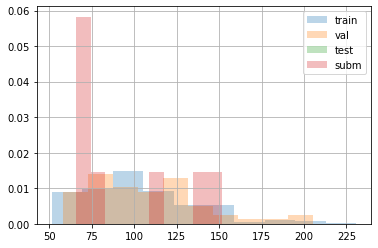

In [89]:
df.loc[df['train'] & (df['srch_destination_id'] == 11197), 'price_usd'].hist(density=True, alpha=0.3, label='train')
df.loc[df['val'] & (df['srch_destination_id'] == 11197), 'price_usd'].hist(density=True, alpha=0.3, label='val')
df.loc[df['test'] & (df['srch_destination_id'] == 11197), 'price_usd'].hist(density=True, alpha=0.3, label='test')
df.loc[df['subm'] & (df['srch_destination_id'] == 11197), 'price_usd'].hist(density=True, alpha=0.3, label='subm')
# df.loc[df['subm'] & (df['srch_destination_id'] == 11197), 'price_usd'].hist(density=True, alpha=0.3)
plt.legend();

the hists are not perfectly the same but price is known in advance in this competition. 

this is tricky. but if we know the price in advance, why not

In [90]:
# Order price per prop_id 
df.sort_values(['prop_id', 'price_usd'], inplace=True)
df['price_index_per_prop_id'] = df.groupby(['prop_id']).cumcount()
df.sort_index(inplace=True)

## Others

**srch_query_affinity_score** - The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative)  A null signifies there are no data (i.e. hotel did not register in any searches)

In [91]:
df['srch_query_affinity_score_prob'] = np.exp(df['srch_query_affinity_score'])

# Feature engineering with respect to the time 

## prop_starrating_monotonic (feature from winner)

In [92]:
# mean_booking_starrating = df[df['train'] & df['booking_bool']]['prop_starrating'].mean()
# print(mean_booking_starrating)

# df['prop_starrating_monotonic'] = abs(df['prop_starrating'] - mean_booking_starrating) 
# df['prop_starrating_monotonic'].hist();

## Booking and clicking probs during train

In [93]:
book_click_prob_per_prop = df[df['train']].groupby(['prop_id'])[['booking_bool', 'click_bool']].mean()
book_click_prob_per_prop.rename(columns={'booking_bool': 'booking_prob_train',
                                         'click_bool': 'click_prob_train'}, inplace=True)
book_click_prob_per_prop

,booking_prob_train,click_prob_train
prop_id,,
1,0.000,0.000000
3,0.000,0.000000
4,0.500,0.500000
5,0.000,0.000000
7,0.000,0.000000
...,...,...
140813,0.000,0.000000
140814,0.000,0.000000
140815,0.000,0.076923


In [94]:
book_click_prob_per_prop['book_per_click'] = book_click_prob_per_prop['booking_prob_train'] / \
    book_click_prob_per_prop['click_prob_train']  # 0/0 will be replaced with nans which is ok

In [95]:
df = pd.merge(df, book_click_prob_per_prop.reset_index(), on='prop_id',
              how='left')
df.shape

(492770, 110)

In [96]:
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date,trip_end_date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id,price_usd_log10_norm_by_prop_id,prop_starrating_norm_by_srch_id,price_index_per_srch_id,price_index_per_srch_destination_id,price_index_per_prop_id,srch_query_affinity_score_prob,booking_prob_train,click_prob_train,book_per_click
0,45562,2012-11-01 00:28:53,24,216,NaN,NaN,219,14944,3.0,4.5,0,5.18,0.2439,5.65,NaN,197.78,0,9402,6,342,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,False,False,False,True,197.78,1186.68,1,4.9361,5.4239,1.263402,7.215632,3.144368,-10.544576,NaN,<NA>,<NA>,39116.9284,2.296182,0.005056,1.770826,0.752049,0.176991,284.291466,NaN,NaN,NaN,NaN,NaN,NaN,-86.511466,-86.511466,902.388534,NaN,NaN,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,65.926645,43.951101,1.819061,1.642970,48.857143,57.0,2012-11-01,2013-10-09,2013-10-15,41,13,10,31,4,4,2013,201341,42,12,10,31,4,4,2013,201342,0.0,1,1.0,False,NaN,-0.110387,NaN,0,2140,9,NaN,0.000000,0.000000,NaN
1,33385,2012-11-07 18:00:57,5,219,NaN,NaN,219,14944,3.0,4.5,0,5.18,0.2439,5.65,32.0,118.00,1,9402,2,21,2,0,1,0,NaN,1549.449951,0,0.0,NaN,0.0,True,False,False,False,118.00,236.00,1467,4.9361,5.4239,1.263402,7.215632,3.144367,-10.544576,NaN,NaN,NaN,13924.0000,2.071882,0.008475,1.770826,0.752049,0.176991,284.291493,NaN,NaN,NaN,NaN,NaN,NaN,-166.291493,-166.291493,-48.291493,NaN,NaN,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,39.333320,26.222216,1.594761,1.418669,3.000000,10.5,2012-11-07,2012-11-28,2012-11-30,48,6,11,30,4,4,2012,201248,48,6,11,30,4,4,2012,201248,0.0,2,2.0,False,-0.733107,-2.079610,-1.019019,8,674,1,NaN,0.000000,0.000000,NaN
2,33385,2012-11-07 18:00:57,5,219,NaN,NaN,219,34151,4.0,4.5,1,5.15,0.2830,5.62,24.0,169.00,0,9402,2,21,2,0,1,0,NaN,1549.420044,0,0.0,NaN,0.0,True,False,False,False,169.00,338.00,1467,4.8670,5.4330,1.457450,6.971121,3.328879,-9.378773,NaN,0.0,NaN,28561.0000,2.227887,0.005917,1.767718,0.749736,0.1779

## Position during train

In [97]:
position_per_prop = df[df['train']].groupby(['prop_id'])[['position']].mean()
position_per_prop.rename(columns={'position': 'mean_position_train'}, inplace=True)
position_per_prop

,mean_position_train
prop_id,
1,29.500
3,9.500
4,11.000
5,31.000
7,24.000
...,...
140813,9.000
140814,20.000
140815,16.000


In [98]:
position_no_random_per_prop = df[df['train'] & (~df['random_bool'])].groupby(['prop_id'])[['position']].mean()
position_no_random_per_prop.rename(columns={'position': 'mean_position_train_when_not_random'}, inplace=True)
position_no_random_per_prop

,mean_position_train_when_not_random
prop_id,
1,31.111111
3,9.500000
4,11.000000
5,31.000000
7,24.000000
...,...
140810,30.000000
140812,27.000000
140813,6.000000


In [99]:
df = pd.merge(df, pd.concat([position_per_prop, position_no_random_per_prop], axis=1).reset_index(), 
              on='prop_id',
              how='left')
df.shape

(492770, 112)

## Aggregations

In [100]:
from features import apply_composite_for_splits

### Price aggregations

#### srch_id

In [101]:
# prices from the country of user for the destination country
groupby_cols = ['srch_id']
feature_value_col = 'prop_starrating'
agg_methods = ["mean", "median", "min", "max"]

df = apply_composite_for_splits(df, 
                                split_cols=None,  # srch_id is independent on split
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods)
df.shape

58936 groups when aggregation by ['srch_id']


(492770, 124)

In [102]:


# prices from the country of user for the destination country
groupby_cols = ['srch_id']
feature_value_col = 'prop_location_score2'
agg_methods = ["mean", "median", "min", "max"]

df = apply_composite_for_splits(df, 
                                split_cols=None,
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods)
df.shape

58936 groups when aggregation by ['srch_id']


(492770, 136)

In [103]:


# prices from the country of user for the destination country
groupby_cols = ['srch_id']
feature_value_col = 'prop_location_score1'
agg_methods = ["mean", "median", "min", "max"]

df = apply_composite_for_splits(df, 
                                split_cols=None,
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods)
df.shape

58936 groups when aggregation by ['srch_id']


(492770, 148)

In [104]:


# prices from the country of user for the destination country
groupby_cols = ['srch_id']
feature_value_col = 'price_usd'
agg_methods = ["mean", "median", "min", "max"]

df = apply_composite_for_splits(df, 
                                split_cols=None,
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods)
df.shape

58936 groups when aggregation by ['srch_id']


(492770, 160)

In [105]:


# prices from the country of user for the destination country
groupby_cols = ['srch_id']
feature_value_col = 'prop_review_score'
agg_methods = ["mean", "min", "max"]

df = apply_composite_for_splits(df, 
                                split_cols=None,
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods)
df.shape

58936 groups when aggregation by ['srch_id']


(492770, 169)

In [106]:
# df.drop(['mean_promotion_flag_per_srch_id', 
#          'promotion_flag_diff_to_mean_promotion_flag_per_srch_id'
#         ], axis=1, inplace=True)


# df = df.join(df.groupby('srch_id')['promotion_flag'].mean().rename('mean_promotion_flag_per_srch_id'), 
#              on='srch_id', how='left')
# df['promotion_flag_diff_to_mean_promotion_flag_per_srch_id'] = df['promotion_flag'] - df['mean_promotion_flag_per_srch_id']


In [107]:
groupby_cols = ['srch_id']
feature_value_col = 'promotion_flag'
agg_methods = ["mean"]

df['promotion_flag'] = df['promotion_flag'].astype('uint8')

df = apply_composite_for_splits(df, 
                                split_cols=None,
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods,
                                relative_diff=False)
df.shape

58936 groups when aggregation by ['srch_id']


(492770, 171)

In [108]:
df[df['promotion_flag'] == 1][['promotion_flag', 'mean_promotion_flag_per_srch_id',
                               'promotion_flag_diff_to_mean_promotion_flag_per_srch_id']]

,promotion_flag,mean_promotion_flag_per_srch_id,promotion_flag_diff_to_mean_promotion_flag_per_srch_id
1,1,0.575758,0.424242
3,1,0.575758,0.424242
4,1,0.575758,0.424242
6,1,0.575758,0.424242
7,1,0.575758,0.424242
...,...,...,...
492721,1,1.000000,0.000000
492727,1,1.000000,0.000000
492738,1,0.500000,0.500000
492743,1,1.000000,0.000000


In [109]:
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date,trip_end_date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id,price_usd_log10_norm_by_prop_id,prop_starrating_norm_by_srch_id,price_index_per_srch_id,price_index_per_srch_destination_id,price_index_per_prop_id,srch_query_affinity_score_prob,booking_prob_train,click_prob_train,book_per_click,mean_position_train,mean_position_train_when_not_random,mean_prop_starrating_per_srch_id,median_prop_starrating_per_srch_id,min_prop_starrating_per_srch_id,max_prop_starrating_per_srch_id,prop_starrating_diff_to_mean_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_mean_prop_starrating_per_srch_id,prop_starrating_diff_to_median_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_median_prop_starrating_per_srch_id,prop_starrating_diff_to_min_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_min_prop_starrating_per_srch_id,prop_starrating_diff_to_max_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_max_prop_starrating_per_srch_id,mean_prop_location_score2_per_srch_id,median_prop_location_score2_per_srch_id,min_prop_location_score2_per_srch_id,max_prop_location_score2_per_srch_id,prop_location_score2_diff_to_mean_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_mean_prop_location_score2_per_srch_id,prop_location_score2_diff_to_median_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_median_prop_location_score2_per_srch_id,prop_location_score2_diff_to_min_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_min_prop_location_score2_per_srch_id,prop_location_score2_diff_to_max_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_max_prop_location_score2_per_srch_id,mean_prop_location_score1_per_srch_id,median_prop_location_score1_per_srch_id,min_prop_location_score1_per_srch_id,max_prop_location_score1_per_srch_id,prop_location_score1_diff_

#### prop_country_id

In [110]:
df.shape

(492770, 171)

In [111]:
# # prices for the hotel country
# groupby_cols = ['prop_country_id']
# feature_value_col = 'price_per_day'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])

# # prices for the hotel country for the season of trip for specific number of rooms
# groupby_cols = ['prop_country_id', 'srch_room_count', 'trip_start_date_quarter']
# feature_value_col = 'price_per_day'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])

In [112]:


# prices from the country of user for the destination country
groupby_cols = ['visitor_location_country_id', 'prop_country_id']
feature_value_col = 'price_per_day'
agg_methods = ["mean", "median", "min", "max"]

df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

1185 groups when aggregation by ['visitor_location_country_id', 'prop_country_id']
352 groups when aggregation by ['visitor_location_country_id', 'prop_country_id']
348 groups when aggregation by ['visitor_location_country_id', 'prop_country_id']
1933 groups when aggregation by ['visitor_location_country_id', 'prop_country_id']


(492770, 183)

In [113]:
# prices from the country of user for the destination country for the season of trip
groupby_cols = ['visitor_location_country_id', 'prop_country_id', 'trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

2068 groups when aggregation by ['visitor_location_country_id', 'prop_country_id', 'trip_start_date_quarter']
521 groups when aggregation by ['visitor_location_country_id', 'prop_country_id', 'trip_start_date_quarter']
501 groups when aggregation by ['visitor_location_country_id', 'prop_country_id', 'trip_start_date_quarter']
3691 groups when aggregation by ['visitor_location_country_id', 'prop_country_id', 'trip_start_date_quarter']


(492770, 195)

In [114]:
# 

# # prices for the hotel country for the season of trip
# groupby_cols = ['prop_country_id', 'trip_start_date_quarter']
# feature_value_col = 'price_per_day'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])

In [115]:
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date,trip_end_date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id,price_usd_log10_norm_by_prop_id,prop_starrating_norm_by_srch_id,price_index_per_srch_id,price_index_per_srch_destination_id,price_index_per_prop_id,srch_query_affinity_score_prob,booking_prob_train,click_prob_train,book_per_click,mean_position_train,mean_position_train_when_not_random,mean_prop_starrating_per_srch_id,median_prop_starrating_per_srch_id,min_prop_starrating_per_srch_id,max_prop_starrating_per_srch_id,prop_starrating_diff_to_mean_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_mean_prop_starrating_per_srch_id,prop_starrating_diff_to_median_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_median_prop_starrating_per_srch_id,prop_starrating_diff_to_min_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_min_prop_starrating_per_srch_id,prop_starrating_diff_to_max_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_max_prop_starrating_per_srch_id,mean_prop_location_score2_per_srch_id,median_prop_location_score2_per_srch_id,min_prop_location_score2_per_srch_id,max_prop_location_score2_per_srch_id,prop_location_score2_diff_to_mean_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_mean_prop_location_score2_per_srch_id,prop_location_score2_diff_to_median_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_median_prop_location_score2_per_srch_id,prop_location_score2_diff_to_min_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_min_prop_location_score2_per_srch_id,prop_location_score2_diff_to_max_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_max_prop_location_score2_per_srch_id,mean_prop_location_score1_per_srch_id,median_prop_location_score1_per_srch_id,min_prop_location_score1_per_srch_id,max_prop_location_score1_per_srch_id,prop_location_score1_diff_

#### srch_destination_id

In [116]:
# prices from the country of search
groupby_cols = ['srch_destination_id']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

5007 groups when aggregation by ['srch_destination_id']
1219 groups when aggregation by ['srch_destination_id']
1233 groups when aggregation by ['srch_destination_id']
8082 groups when aggregation by ['srch_destination_id']


In [117]:


# prices from the country of user for the search country for the season of trip
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

10027 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter']
1658 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter']
1655 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter']
21548 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter']


In [118]:


# # prices from the country of user for the search country
# groupby_cols = ['visitor_location_country_id', 'srch_destination_id']
# feature_value_col = 'price_per_day'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])

# # prices from the country of user for the season of trip
# groupby_cols = ['srch_destination_id', 'trip_start_date_quarter']
# feature_value_col = 'price_per_day'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])


# prices from the country of search for the specific number of rooms for the season of trip
groupby_cols = ['srch_destination_id', 'srch_room_count', 'trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

8548 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'trip_start_date_quarter']
1580 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'trip_start_date_quarter']
1590 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'trip_start_date_quarter']
16378 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'trip_start_date_quarter']


In [119]:
gc.collect()
df = downcast(df)
df.memory_usage().sum() / 1024**2

  0%|          | 0/231 [00:00<?, ?it/s]

398.5108947753906

#### prop_id

In [120]:
# prices for the hotel
groupby_cols = ['prop_id']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

75845 groups when aggregation by ['prop_id']
27109 groups when aggregation by ['prop_id']
27563 groups when aggregation by ['prop_id']
28713 groups when aggregation by ['prop_id']


(492770, 243)

In [121]:
# CONSTANT
# groupby_cols = ['prop_id']
# feature_value_col = 'srch_query_affinity_score'
# df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])
# df.shape

In [122]:


# prices for the user country for specific hotel
groupby_cols = ['visitor_location_country_id', 'prop_id']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

147070 groups when aggregation by ['visitor_location_country_id', 'prop_id']
32791 groups when aggregation by ['visitor_location_country_id', 'prop_id']
33192 groups when aggregation by ['visitor_location_country_id', 'prop_id']
35771 groups when aggregation by ['visitor_location_country_id', 'prop_id']


In [123]:
# prices for the user country for specific hotel for the season of trip
groupby_cols = ['visitor_location_country_id', 'prop_id', 'trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "min", "max"])

df.shape

217127 groups when aggregation by ['visitor_location_country_id', 'prop_id', 'trip_start_date_quarter']
39078 groups when aggregation by ['visitor_location_country_id', 'prop_id', 'trip_start_date_quarter']
39839 groups when aggregation by ['visitor_location_country_id', 'prop_id', 'trip_start_date_quarter']
43330 groups when aggregation by ['visitor_location_country_id', 'prop_id', 'trip_start_date_quarter']


(492770, 264)

In [124]:
# prices for specific hotel for the season of trip
groupby_cols = ['prop_id', 'trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "max"])

df.shape

157931 groups when aggregation by ['prop_id', 'trip_start_date_quarter']
36475 groups when aggregation by ['prop_id', 'trip_start_date_quarter']
37274 groups when aggregation by ['prop_id', 'trip_start_date_quarter']
39671 groups when aggregation by ['prop_id', 'trip_start_date_quarter']


(492770, 273)

In [125]:
# prices for specific hotel with specific number of rooms for the season of trip
groupby_cols = ['prop_id', 'srch_room_count','trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "min"])

df.shape

177988 groups when aggregation by ['prop_id', 'srch_room_count', 'trip_start_date_quarter']
37432 groups when aggregation by ['prop_id', 'srch_room_count', 'trip_start_date_quarter']
38382 groups when aggregation by ['prop_id', 'srch_room_count', 'trip_start_date_quarter']
41023 groups when aggregation by ['prop_id', 'srch_room_count', 'trip_start_date_quarter']


(492770, 279)

#### prop_starrating

In [126]:


# prices for the location of user for the star rating of the hotel
groupby_cols = ['visitor_location_country_id', 'prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "max"])
df.shape

552 groups when aggregation by ['visitor_location_country_id', 'prop_starrating']
288 groups when aggregation by ['visitor_location_country_id', 'prop_starrating']
285 groups when aggregation by ['visitor_location_country_id', 'prop_starrating']
502 groups when aggregation by ['visitor_location_country_id', 'prop_starrating']


(492770, 288)

In [127]:
# prices for the location of user for the search location for the star rating of the hotel for the season of trip
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 
                'trip_start_date_quarter', 'prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["median", "max"])
df.shape

30396 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
4963 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
4951 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
28099 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']


(492770, 294)

In [128]:
# prices for the location of user for the search location for the star rating of the hotel
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 'prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["median", "max"])
df.shape

23020 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_starrating']
4404 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_starrating']
4404 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_starrating']
20553 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_starrating']


(492770, 300)

In [129]:


# prices for the search location for the star rating of the hotel
groupby_cols = ['srch_destination_id', 'prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["min", "max"])
df.shape

15519 groups when aggregation by ['srch_destination_id', 'prop_starrating']
3750 groups when aggregation by ['srch_destination_id', 'prop_starrating']
3785 groups when aggregation by ['srch_destination_id', 'prop_starrating']
12988 groups when aggregation by ['srch_destination_id', 'prop_starrating']


(492770, 306)

In [130]:


# prices for the search location for the star rating of the hotel for the season of trip
groupby_cols = ['srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min"])

24214 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
4640 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
4669 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
20964 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']


In [131]:


groupby_cols = ['srch_destination_id', 'srch_room_count','prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "min", "max"])
df.shape

17729 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_starrating']
3962 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_starrating']
4020 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_starrating']
15076 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_starrating']


(492770, 324)

#### prop_review_score

In [132]:


groupby_cols = ['visitor_location_country_id', 'prop_review_score']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median"])
df.shape

1053 groups when aggregation by ['visitor_location_country_id', 'prop_review_score']
526 groups when aggregation by ['visitor_location_country_id', 'prop_review_score']
507 groups when aggregation by ['visitor_location_country_id', 'prop_review_score']
775 groups when aggregation by ['visitor_location_country_id', 'prop_review_score']


(492770, 330)

In [133]:
 

groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 
                'trip_start_date_quarter', 'prop_review_score']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["median", "max"])

56143 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
8910 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
8948 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
32528 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']


In [134]:


groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 'prop_review_score']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "min"])
df.shape

43076 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_review_score']
8019 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_review_score']
8054 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_review_score']
24896 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_review_score']


(492770, 342)

In [135]:
# 

# groupby_cols = ['srch_destination_id', 'prop_review_score']
# feature_value_col = 'price_per_day'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])
# df.shape

In [136]:


groupby_cols = ['srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"],
                                relative_diff=False)

45777 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
8395 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
8494 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
25733 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']


In [137]:


groupby_cols = ['srch_destination_id', 'srch_room_count', 'prop_review_score']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "min", "max"])
df.shape

34067 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_review_score']
7304 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_review_score']
7475 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_review_score']
19393 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_review_score']


(492770, 359)

#### prop_location_score2 rounded

In [138]:
df['prop_location_score2_round'] = df['prop_location_score2'].round(1)

In [139]:
groupby_cols = ['prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

11 groups when aggregation by ['prop_location_score2_round']
11 groups when aggregation by ['prop_location_score2_round']
11 groups when aggregation by ['prop_location_score2_round']
11 groups when aggregation by ['prop_location_score2_round']


(492770, 372)

In [140]:


groupby_cols = ['visitor_location_country_id', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

791 groups when aggregation by ['visitor_location_country_id', 'prop_location_score2_round']
365 groups when aggregation by ['visitor_location_country_id', 'prop_location_score2_round']
355 groups when aggregation by ['visitor_location_country_id', 'prop_location_score2_round']
665 groups when aggregation by ['visitor_location_country_id', 'prop_location_score2_round']


(492770, 384)

In [141]:
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 
                'trip_start_date_quarter', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

30669 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']
4977 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']
5056 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']
20981 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']


(492770, 396)

In [142]:
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

22910 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_location_score2_round']
4390 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_location_score2_round']
4484 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_location_score2_round']
14944 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_location_score2_round']


(492770, 408)

In [143]:
groupby_cols = ['srch_destination_id', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

15096 groups when aggregation by ['srch_destination_id', 'prop_location_score2_round']
3731 groups when aggregation by ['srch_destination_id', 'prop_location_score2_round']
3850 groups when aggregation by ['srch_destination_id', 'prop_location_score2_round']
8516 groups when aggregation by ['srch_destination_id', 'prop_location_score2_round']


In [144]:
groupby_cols = ['srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

24141 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']
4649 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']
4772 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']
14657 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']


In [145]:
groupby_cols = ['srch_destination_id', 'srch_room_count', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

df.shape

17351 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_location_score2_round']
3942 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_location_score2_round']
4096 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_location_score2_round']
10165 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_location_score2_round']


(492770, 444)

#### Time aggregations 
Based on season\month 

To calc based on weekday\day), make day_features=True in start day of trip feature calculation

In [146]:
df.shape

(492770, 444)

In [147]:
# 

# groupby_cols = ['trip_start_date_month']
# feature_value_col = 'price_per_day'
# comparison_cols = ['visitor_hist_adr_usd', 'prop_historical_price']
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max", 'sum'],
#                                 comparison_cols=comparison_cols)

In [148]:
gc.collect()

45

In [149]:


groupby_cols = ['trip_start_date_month', 'prop_id']
feature_value_col = 'price_per_day'
comparison_cols = ['visitor_hist_adr_usd', 'prop_historical_price']
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max", 'sum'],
                                comparison_cols=comparison_cols)
df.shape

232030 groups when aggregation by ['trip_start_date_month', 'prop_id']
40625 groups when aggregation by ['trip_start_date_month', 'prop_id']
41342 groups when aggregation by ['trip_start_date_month', 'prop_id']
44870 groups when aggregation by ['trip_start_date_month', 'prop_id']


(492770, 473)

In [150]:
gc.collect()

15

In [151]:
# 

# groupby_cols = ['trip_start_date_month', 'srch_destination_id']
# feature_value_col = 'price_per_day'
# comparison_cols = ['visitor_hist_adr_usd', 'prop_historical_price']
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max", 'sum'],
#                                 comparison_cols=comparison_cols)

# df.shape

In [152]:
# 

# groupby_cols = ['trip_start_date_quarter']
# feature_value_col = 'price_per_day'
# comparison_cols = ['visitor_hist_adr_usd', 'prop_historical_price']
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max", 'sum'],
#                                 comparison_cols=comparison_cols)
# df.shape

In [153]:
df.memory_usage().sum() / 1024**2

853.4148406982422

## Calculate position per prop_id

In [154]:
# groupby_cols = ['prop_id']
# feature_value_col = 'position'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                  groupby_cols=groupby_cols,
#                                  feature_value_col=feature_value_col,
#                                  agg_methods=["mean", "median", "min", "max"])

# groupby_cols = ['trip_start_date_week', 'prop_id']
# feature_value_col = 'position'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                  groupby_cols=groupby_cols,
#                                  feature_value_col=feature_value_col,
#                                  agg_methods=["mean", "median", "min", "max"])

# groupby_cols = ['trip_start_date_month', 'prop_id']
# feature_value_col = 'position'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                  groupby_cols=groupby_cols,
#                                  feature_value_col=feature_value_col,
#                                  agg_methods=["mean", "median", "min", "max"])

# groupby_cols = ['trip_start_date_quarter', 'prop_id']
# feature_value_col = 'position'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                  groupby_cols=groupby_cols,
#                                  feature_value_col=feature_value_col,
#                                  agg_methods=["mean", "median", "min", "max"])

## Hotel position in previous and next search + avg of those

In [155]:
# #order df by prop_id and time of viewing the website
# df.sort_values(['prop_id','date_time'], inplace=True)

# #shift position to find previous and next position
# #shift prop_id to find where the prop_id changes by shifting and setting the position to nan there
# #i.e if the next row is for an other prop_id the position from that row cannot be used and is replaced with a nan
# #shift by multiple lines in order to skip missing data
# df['pos_next'] = df['position'].shift(-1)
# df.loc[df['prop_id'] != df['prop_id'].shift(-1), 'pos_next'] = np.nan
# df['pos_next2'] = df['position'].shift(-2)
# df.loc[df['prop_id'] != df['prop_id'].shift(-2), 'pos_next2'] = np.nan
# df['pos_next3'] = df['position'].shift(-3)
# df.loc[df['prop_id'] != df['prop_id'].shift(-3), 'pos_next3'] = np.nan

# df['pos_prev'] = df['position'].shift(1)
# df.loc[df['prop_id'] != df['prop_id'].shift(1), 'pos_prev'] = np.nan
# df['pos_prev2'] = df['position'].shift(2)
# df.loc[df['prop_id'] != df['prop_id'].shift(2), 'pos_prev2'] = np.nan
# df['pos_prev3'] = df['position'].shift(3)
# df.loc[df['prop_id'] != df['prop_id'].shift(3), 'pos_prev3'] = np.nan


# #fill missing pos_next and pos_prev from columns shifted by multiple rows
# df.loc[df['pos_next'].isna(), 'pos_next'] = df[df['pos_next'].isna()]['pos_next2']
# df.loc[df['pos_next'].isna(), 'pos_next'] = df[df['pos_next'].isna()]['pos_next3']
# df.loc[df['pos_prev'].isna(), 'pos_prev'] = df[df['pos_prev'].isna()]['pos_prev2']
# df.loc[df['pos_prev'].isna(), 'pos_prev'] = df[df['pos_prev'].isna()]['pos_prev3']
# df['pos_mean2'] = (df['pos_next'] + df['pos_prev']) / 2

# df.drop(['pos_next2', 'pos_next3', 'pos_prev2', 'pos_prev3'], axis=1, inplace=True)
# df.sort_index(inplace=True)

In [156]:
df

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date,trip_end_date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id,price_usd_log10_norm_by_prop_id,prop_starrating_norm_by_srch_id,price_index_per_srch_id,price_index_per_srch_destination_id,price_index_per_prop_id,srch_query_affinity_score_prob,booking_prob_train,click_prob_train,book_per_click,mean_position_train,mean_position_train_when_not_random,mean_prop_starrating_per_srch_id,median_prop_starrating_per_srch_id,min_prop_starrating_per_srch_id,max_prop_starrating_per_srch_id,prop_starrating_diff_to_mean_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_mean_prop_starrating_per_srch_id,prop_starrating_diff_to_median_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_median_prop_starrating_per_srch_id,prop_starrating_diff_to_min_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_min_prop_starrating_per_srch_id,prop_starrating_diff_to_max_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_max_prop_starrating_per_srch_id,mean_prop_location_score2_per_srch_id,median_prop_location_score2_per_srch_id,min_prop_location_score2_per_srch_id,max_prop_location_score2_per_srch_id,prop_location_score2_diff_to_mean_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_mean_prop_location_score2_per_srch_id,prop_location_score2_diff_to_median_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_median_prop_location_score2_per_srch_id,prop_location_score2_diff_to_min_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_min_prop_location_score2_per_srch_id,prop_location_score2_diff_to_max_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_max_prop_location_score2_per_srch_id,mean_prop_location_score1_per_srch_id,median_prop_location_score1_per_srch_id,min_prop_location_score1_per_srch_id,max_prop_location_score1_per_srch_id,prop_location_score1_diff_

# Data split

In [157]:
from features_dict import CAT_FEATURES, BOOL_COLS

In [158]:
# for c in CAT_FEATURES:
#     if c in df.columns:
#         df[c] = df[c].astype('category')
        
# for c in BOOL_COLS:
#     if c in df.columns:
#         df[c] = df[c].astype(bool)

In [159]:
df = downcast(df)

  0%|          | 0/473 [00:00<?, ?it/s]

In [160]:
df.memory_usage().sum() / 1024**2

853.4148406982422

In [161]:
dtps_upd = df.dtypes.apply(lambda x: x.name).to_dict()

for k in dtps_upd:
    if (k in dtps) and (dtps[k] != dtps_upd[k]):
        print(f"{k} was: {dtps[k]}, become {dtps_upd[k]}")

srch_id was: uint32, become int32
date_time was: object, become datetime64[ns]
site_id was: uint8, become int8
visitor_location_country_id was: uint8, become int16
prop_country_id was: uint8, become int16
prop_id was: uint32, become int32
prop_brand_bool was: uint8, become int8
position was: uint8, become float32
srch_destination_id was: uint16, become int16
srch_length_of_stay was: uint8, become int8
srch_booking_window was: uint16, become int16
srch_adults_count was: uint8, become int8
srch_children_count was: uint8, become int8
srch_room_count was: uint8, become int8
srch_saturday_night_bool was: uint8, become int8
random_bool was: uint8, become int8
click_bool was: uint8, become float32
booking_bool was: uint8, become float32


In [162]:
df.shape

(492770, 473)

In [163]:
# no need for that if we don't do time-series split
df.sort_values([group_col, time_col, 'prop_id'], inplace=True)

In [164]:
df.to_pickle(os.path.join(data_path, 'full_df_26_may.pickle'))

In [165]:
# further all feature engineering will be separate

subm_df = deepcopy(df[df['subm'] == True])
df = deepcopy(df[df['subm'] == False])

subm_df.drop(['subm'] + ['train', 'test', 'val'] + drop_cols, axis=1, inplace=True)
df.drop(['subm'], axis=1, inplace=True)

df.shape, subm_df.shape

((443278, 472), (49492, 465))

In [166]:
X = df.drop(drop_cols, axis=1)

y = df[['booking_bool', 'click_bool']].parallel_apply(get_target, axis=1)

In [167]:
# split the data into separate dataframes
# according to the paper https://arxiv.org/pdf/1311.7679v1.pdf

X_test = X[X['test']].drop(['train', 'test', 'val'], axis=1)
y_test = y.loc[X_test.index]

X_val = X[X['val']].drop(['train', 'test', 'val'], axis=1)
y_val = y.loc[X_val.index]

X_train = X[~X.index.isin(X_test.index.union(X_val.index))].drop(['train', 'test', 'val'], axis=1)
y_train = y.loc[X_train.index]

# from sklearn.model_selection import GroupShuffleSplit

# gss = GroupShuffleSplit(n_splits=1, train_size=.9, random_state=None)
# train_val, test_idx = next(gss.split(X, y, groups=X[group_col]))
# X_train_val = X.iloc[train_val, :]
# y_train_val = y.iloc[train_val]
# X_test = X.iloc[test_idx, :]
# y_test = y.iloc[test_idx]

# gss = GroupShuffleSplit(n_splits=1, train_size=.9, random_state=None)
# train_idx, val_idx = next(gss.split(X_train_val, y_train_val, groups=X_train_val[group_col]))
# X_train = X_train_val.iloc[train_idx, :]
# y_train = y_train_val.iloc[train_idx]
# X_val = X_train_val.iloc[val_idx, :]
# y_val = y_train_val.iloc[val_idx]

# X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test = GroupShuffleSplit(X, y, groups,
#                                                                                                  group_array=groups,
#                                                                                                  train_size=0.9)
# # del X, y

# X_train, X_val, y_train, y_val, groups_train, groups_val = train_test_group_split(X_train_val,
#                                                                                   y_train_val,
#                                                                                   groups_train_val,
#                                                                                   group_array=groups_train_val,
#                                                                                   train_size=0.9)

In [168]:
X_train.shape, X_val.shape, X_test.shape, subm_df.shape

((354769, 465), (44169, 465), (44340, 465), (49492, 465))

In [169]:
# make sure that this is empty
assert set(X_train[group_col]).intersection(set(X_test[group_col])) == set()
assert set(X_train[group_col]).intersection(set(X_val[group_col])) == set()


assert X_train.shape[1] == X_val.shape[1]
assert X_val.shape[1] == X_test.shape[1]
assert X_test.shape[1] == subm_df.shape[1]

check that submission search ids are presented in both train, val, test

In [170]:
len(set(X_train[group_col]).intersection(set(subm_df[group_col])))/len(X_train)

0.005107548855734295

In [171]:
len(set(X_val[group_col]).intersection(set(subm_df[group_col])))/len(X_val)

0.0054110348887228595

In [172]:
len(set(X_test[group_col]).intersection(set(subm_df[group_col])))/len(X_test)

0.005051871898962562

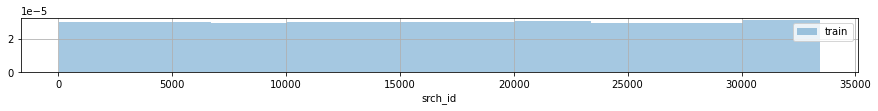

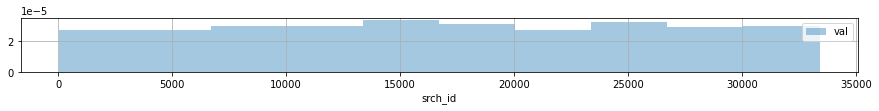

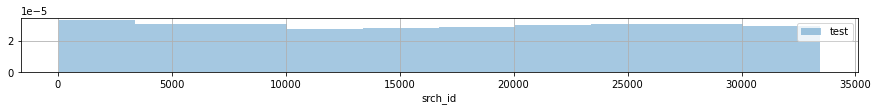

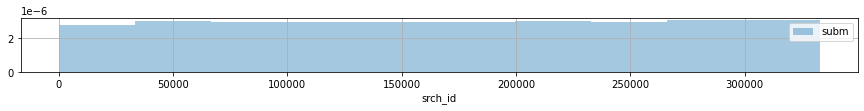

In [173]:
for df_hist, name in [(X_train, 'train'), (X_val, 'val'), (X_test, 'test'), (subm_df, 'subm')]:
    plt.figure(figsize=(15, 1))
    df_hist[group_col].hist(alpha=0.4, label=name, density=True, color='tab:blue')
    plt.xlabel(group_col)
    plt.legend()    

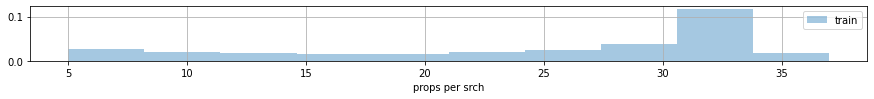

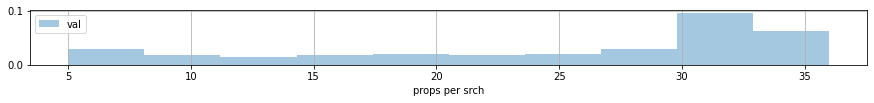

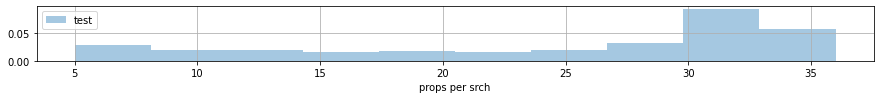

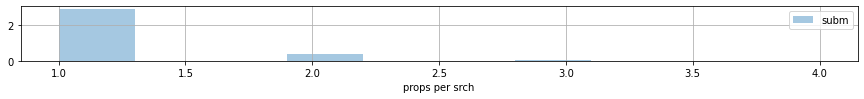

In [174]:
for df_hist, name in [(X_train, 'train'), (X_val, 'val'), (X_test, 'test'), (subm_df, 'subm')]:
    plt.figure(figsize=(15, 1))
    df_hist.groupby([group_col])['prop_id'].apply(len).hist(alpha=0.4, label=name, density=True, color='tab:blue')
    plt.xlabel('props per srch')
    plt.legend()    

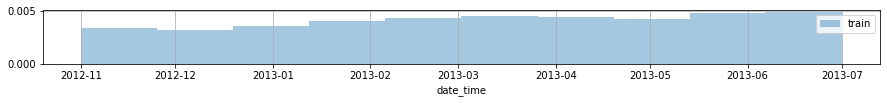

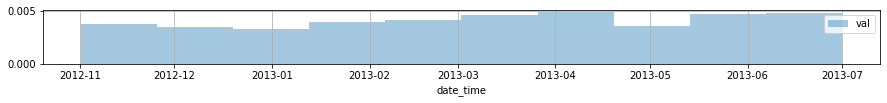

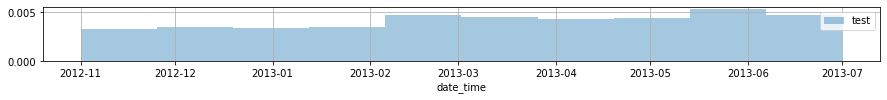

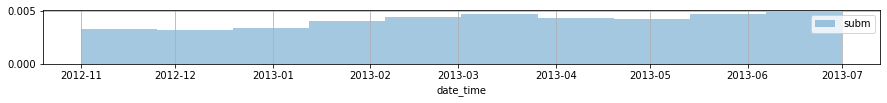

In [175]:
col = time_col
for df_hist, name in [(X_train, 'train'), (X_val, 'val'), (X_test, 'test'), (subm_df, 'subm')]:
    plt.figure(figsize=(15, 1))
    df_hist[col].hist(alpha=0.4, label=name, density=True, color='tab:blue')
    plt.xlabel(col)
    plt.legend()    

# Correlations

In [176]:
# profile = ProfileReport(X_train, title="Pandas Profiling Report", minimal=True)

In [177]:
# profile.to_notebook_iframe()

In [178]:
for c in subm_df.columns:
    df_nans = df[c].isna().mean().round(4) * 100
    subm_df_nans = subm_df[c].isna().mean().round(4) * 100
    if df_nans == subm_df_nans == 0:
        continue
    print(f"{round(df_nans, 2)} vs {round(subm_df_nans, 2)} | {c}")
    assert subm_df_nans != 100.

94.55 vs 94.95 | visitor_hist_starrating
94.52 vs 94.93 | visitor_hist_adr_usd
3.61 vs 3.54 | prop_starrating
0.15 vs 0.17 | prop_review_score
22.85 vs 21.99 | prop_location_score2
14.04 vs 14.2 | prop_log_historical_price
93.19 vs 93.59 | srch_query_affinity_score
32.68 vs 33.05 | orig_destination_distance
22.85 vs 21.99 | prop_location_score_diff
22.85 vs 21.99 | prop_location_score_sum
22.85 vs 21.99 | prop_location_score_mul
22.85 vs 21.99 | prop_location_score_diff_log
22.85 vs 21.99 | prop_location_score_sum_log
22.85 vs 21.99 | prop_location_score_mul_log
88.25 vs 88.5 | ratio_of_comp_with_lower_price_than_expedia
83.48 vs 83.3 | comp5_rate_percent_diff_signed
88.36 vs 87.89 | comp8_rate_percent_diff_signed
14.04 vs 14.2 | prop_log_historical_price_pow_0.33
14.04 vs 14.2 | prop_log_historical_price_log_10
14.04 vs 14.2 | prop_log_historical_price_reciprocal
14.04 vs 14.2 | prop_historical_price
94.52 vs 94.93 | price_diff_to_usr_hist
94.52 vs 94.93 | price_ratio_to_usr_hist
94.5

22.85 vs 21.99 | price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_location_score2_round
22.85 vs 21.99 | price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_location_score2_round
22.85 vs 21.99 | price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_location_score2_round
22.85 vs 21.99 | price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_location_score2_round
22.85 vs 21.99 | price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_location_score2_round
22.85 vs 21.99 | price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_location_score2_round
22.85 vs 21.99 | mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_date_quarter_per_prop_location_score2_round
22.85 vs 21.99 | median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_trip_start_da

# Save tables

In [179]:
X_val.reset_index().to_feather(os.path.join(data_path, 'X_val.feather'))
y_val.to_frame('target').reset_index().to_feather(os.path.join(data_path, 'y_val.feather'))
# groups_val.reset_index().to_feather(os.path.join(data_path, 'groups_val.feather'))
print('val is done')

X_train.reset_index().to_feather(os.path.join(data_path, 'X_train.feather'))
y_train.to_frame('target').reset_index().to_feather(os.path.join(data_path, 'y_train.feather'))
# groups_train.reset_index().to_feather(os.path.join(data_path, 'groups_train.feather'))
print('train is done')

X_test.reset_index().to_feather(os.path.join(data_path, 'X_test.feather'))
y_test.to_frame('target').reset_index().to_feather(os.path.join(data_path, 'y_test.feather'))
# groups_test.reset_index().to_feather(os.path.join(data_path, 'groups_test.feather'))
print('test is done')

subm_df.reset_index().to_feather(os.path.join(data_path, 'submission_df_preprocessed.feather'))
print('submission is done')

val is done
train is done
test is done
submission is done
